In [34]:
import matplotlib.pyplot as plt
import numpy as np # Para Algebra Linear
import os
import pandas as pd # Para processamento de dados, arquivo CSV e DataFrames
import sqlite3
from sqlalchemy import create_engine

## CARREGANDO O BANCO DE DADOS E TESTANDO A CONEXÃO
path_sql = 'data'
path_sql= os.path.join(path_sql, 'travel.sqlite')
conn = sqlite3.connect(path_sql)
cursor = conn.cursor()
print(path_sql)


tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
print(tables)

data/travel.sqlite
    type             name         tbl_name  rootpage  \
0  table   aircrafts_data   aircrafts_data         2   
1  table    airports_data    airports_data         3   
2  table  boarding_passes  boarding_passes         4   
3  table         bookings         bookings         5   
4  table          flights          flights         6   
5  table            seats            seats         7   
6  table   ticket_flights   ticket_flights         8   
7  table          tickets          tickets         9   

                                                 sql  
0  CREATE TABLE aircrafts_data (\r\n    aircraft_...  
1  CREATE TABLE airports_data (\r\n    airport_co...  
2  CREATE TABLE boarding_passes (\r\n    ticket_n...  
3  CREATE TABLE bookings (\r\n    book_ref charac...  
4  CREATE TABLE flights (\r\n    flight_id intege...  
5  CREATE TABLE seats (\r\n    aircraft_code char...  
6  CREATE TABLE ticket_flights (\r\n    ticket_no...  
7  CREATE TABLE tickets (\r\n    tic

## As tabelas mais interessantes e as suas colunas

1. Table: flights:
- flight_id: helpful for counting flights
- departure_airport/arrival_airport: These two columns can help us establish a route for each flight. We can use this to know which airports serve as hubs, what are the most common routes, the rarest - flights, etc. This data can be linked with the airports dataset for enrichment.
- actual_departure/actual_arrival: can use this to determine longest/shortest flights
- aircraft_code: can be used to know which kind of airplanes are travelling which routes
- status: could check how many flights get cancelled by airline, city, etc

2. Table: aircrafts_data:
- Range: We can use this to determine which airplaines are situatable for which routes

3. Table: airports_data:
- This table can serve as enrichment for the flights table as we can extract additional information out about each airport
- city: with enrichment we can use this to know which cities serve as flight hubs, which cities have the most/fewest number of connecting routes
- coordinates: via enrichment, we can use this to figure out what the longest/shortest flights are

4. Table: ticket_flights:
- flight_id : conencts this table to the main flights table
- amount: indicates how much the passenger paid
- fare_conditions: the seat class they travelled in

In [35]:
#%uv add --upgrade ipython-sql sqlalchemy   #Talvez seja necessário reiniciar o kernel
#%uv rmv --upgrade sqlalchemy  # 


In [36]:
%load_ext sql
%sql sqlite:///data/travel.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [37]:
## O comando %%sql roda o código SQL na célula inteira
engine = create_engine("sqlite:///data/travel.sqlite")
df = pd.read_sql_query("SELECT * FROM flights LIMIT 5;", engine)
print(df.head())

   flight_id flight_no     scheduled_departure       scheduled_arrival  \
0       1185    PG0134  2017-09-10 09:50:00+03  2017-09-10 14:55:00+03   
1       3979    PG0052  2017-08-25 14:50:00+03  2017-08-25 17:35:00+03   
2       4739    PG0561  2017-09-05 12:30:00+03  2017-09-05 14:15:00+03   
3       5502    PG0529  2017-09-12 09:50:00+03  2017-09-12 11:20:00+03   
4       6938    PG0461  2017-09-04 12:25:00+03  2017-09-04 13:20:00+03   

  departure_airport arrival_airport     status aircraft_code actual_departure  \
0               DME             BTK  Scheduled           319               \N   
1               VKO             HMA  Scheduled           CR2               \N   
2               VKO             AER  Scheduled           763               \N   
3               SVO             UFA  Scheduled           763               \N   
4               SVO             ULV  Scheduled           SU9               \N   

  actual_arrival  
0             \N  
1             \N  
2          

In [38]:
display(df)

,flight_id,flight_no,scheduled_departure,scheduled_arrival,departure_airport,arrival_airport,status,aircraft_code,actual_departure,actual_arrival
0,1185,PG0134,2017-09-10 09:50:00+03,2017-09-10 14:55:00+03,DME,BTK,Scheduled,319,\N,\N
1,3979,PG0052,2017-08-25 14:50:00+03,2017-08-25 17:35:00+03,VKO,HMA,Scheduled,CR2,\N,\N
2,4739,PG0561,2017-09-05 12:30:00+03,2017-09-05 14:15:00+03,VKO,AER,Scheduled,763,\N,\N
3,5502,PG0529,2017-09-12 09:50:00+03,2017-09-12 11:20:00+03,SVO,UFA,Scheduled,763,\N,\N
4,6938,PG0461,2017-09-04 12:25:00+03,2017-09-04 13:20:00+03,SVO,ULV,Scheduled,SU9,\N,\N


A tabela de voos, por si só, não possui muitos campos que ofereçam grande valor para análise. As cidades de partida e chegada são interessantes, pois podem mostrar os aeroportos com o maior número de voos de entrada e/ou saída.

Os resultados abaixo mostram os 5 aeroportos com maior e menor número de voos de saída. A mesma análise pode ser realizada para voos de entrada.

In [39]:
departure_airport=pd.read_sql("""WITH RankedFlights AS (
                                    SELECT departure_airport, COUNT(*) as flights
                                    FROM flights
                                    GROUP BY departure_airport
                                )
                            SELECT departure_airport, flights FROM (
                                SELECT *, ROW_NUMBER() OVER (ORDER BY flights DESC) AS rn_desc,
                                    ROW_NUMBER() OVER (ORDER BY flights ASC) AS rn_asc
                                FROM RankedFlights
                            ) Ranked
                            WHERE rn_desc <= 5 OR rn_asc <= 5;""", conn)

In [40]:
departure_airport

,departure_airport,flights
0,DME,3217
1,SVO,2981
2,LED,1900
3,VKO,1719
4,OVB,1055
5,NYA,27
6,PYJ,27
7,PKC,26
8,KXK,18
9,USK,18


O interessante sobre os códigos de aeroporto é que, quando combinados, eles formam a rota ou o trajeto de voo. Agrupando-os pelas cidades de partida e chegada, podemos ver quais combinações ocorrem com mais frequência, revelando assim as rotas mais relevantes.

In [41]:
most_used_routes = pd.read_sql("""SELECT departure_airport, arrival_airport, COUNT(*) AS flight_count
                               FROM flights
                               GROUP BY departure_airport, arrival_airport ORDER BY flight_count DESC LIMIT 10;""", conn)

print(most_used_routes)

  departure_airport arrival_airport  flight_count
0               LED             SVO           305
1               SVO             LED           305
2               DME             LED           244
3               LED             DME           244
4               BZK             DME           183
5               BZK             SVO           183
6               BZK             VKO           183
7               DME             BZK           183
8               LED             VKO           183
9               SVO             BZK           183


Os códidgos dos aeroportos(chegada e saída) não dizem muito sobre as cidades relacionadas ou até mesmo o país. Por isso, podemos explorar outra coluna. Mas usando da tabela de airports, nós podemos melhorar esse percepção.

In [42]:
df=pd.read_sql("SELECT * FROM airports_data LIMIT 5;", conn)

In [43]:
df.head()

,airport_code,airport_name,city,coordinates,timezone
0,YKS,"{""en"": ""Yakutsk Airport"", ""ru"": ""Якутск""}","{""en"": ""Yakutsk"", ""ru"": ""Якутск""}","(129.77099609375,62.0932998657226562)",Asia/Yakutsk
1,MJZ,"{""en"": ""Mirny Airport"", ""ru"": ""Мирный""}","{""en"": ""Mirnyj"", ""ru"": ""Мирный""}","(114.03900146484375,62.534698486328125)",Asia/Yakutsk
2,KHV,"{""en"": ""Khabarovsk-Novy Airport"", ""ru"": ""Хабар...","{""en"": ""Khabarovsk"", ""ru"": ""Хабаровск""}","(135.18800354004,48.5279998779300001)",Asia/Vladivostok
3,PKC,"{""en"": ""Yelizovo Airport"", ""ru"": ""Елизово""}","{""en"": ""Petropavlovsk"", ""ru"": ""Петропавловск-К...","(158.453994750976562,53.1679000854492188)",Asia/Kamchatka
4,UUS,"{""en"": ""Yuzhno-Sakhalinsk Airport"", ""ru"": ""Хом...","{""en"": ""Yuzhno-Sakhalinsk"", ""ru"": ""Южно-Сахали...","(142.718002319335938,46.8886985778808594)",Asia/Sakhalin


In [44]:
df_cities=pd.read_sql("""SELECT fl.flight_id, f.city AS from_city, f.coordinates AS from_coordinates, t.city AS to_city, t.coordinates AS to_coordinates FROM 
            flights AS fl
            LEFT JOIN airports_data AS f
            ON fl.departure_airport = f.airport_code
            LEFT JOIN airports_data AS t
            ON fl.arrival_airport = t.airport_code    
            limit 10;""", conn
               )

# O apelido na linha from flights as fl. A partir desse momento, o SQL entende que qualquer coisa que comece com fl. refere-se à tabela flights.
# Por causa do risco de ambiguidade, quando fazemos um JOIN entre duas ou mais tabelas, é comum que ambas tenham colunas com o mesmo nome (como id, name ou created_at) das chaves principais.
# Se você escrever apenas SELECT flight_id, o banco de dados pode ficar confuso: "Este ID vem da tabela de voos ou da tabela de aeroportos?".
# Usando fl.flight_id, você remove qualquer dúvida e garante que o dado venha da origem correta. # 

# Além disso, Legibilidade e Velocidade, né? Imagine ter que escrever o nome completo da tabela toda vez que for chamar uma coluna: 
#
#Sem alias: flights.flight_id, flights.departure_airport, flights.arrival_airport
#X
#Com alias: fl.flight_id, fl.departure_airport, fl.arrival_airport

# Só para lembrar dos Joins
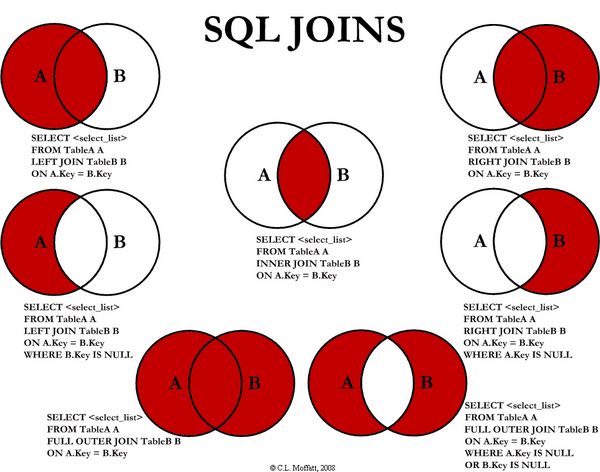
![image.png](https://terminalroot.com.br/assets/img/mysql/joins-mysql.jpg)

In [45]:
df_cities.head()

,flight_id,from_city,from_coordinates,to_city,to_coordinates
0,1185,"{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.9062995910644531,55.4087982177734375)","{""en"": ""Bratsk"", ""ru"": ""Братск""}","(101.697998046875,56.3706016540527344)"
1,3979,"{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.2615013122999983,55.5914993286000012)","{""en"": ""Khanty-Mansiysk"", ""ru"": ""Ханты-Мансийск""}","(69.0860977172851562,61.0284996032714844)"
2,4739,"{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.2615013122999983,55.5914993286000012)","{""en"": ""Sochi"", ""ru"": ""Сочи""}","(39.9566001892089986,43.4499015808110016)"
3,5502,"{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.4146000000000001,55.9725990000000024)","{""en"": ""Ufa"", ""ru"": ""Уфа""}","(55.8744010925289984,54.5574989318850001)"
4,6938,"{""en"": ""Moscow"", ""ru"": ""Москва""}","(37.4146000000000001,55.9725990000000024)","{""en"": ""Ulyanovsk"", ""ru"": ""Ульяновск""}","(48.2266998291000064,54.2682991027999932)"


In [ ]:
# A tabela temporária
conn.execute("""CREATE TEMP TABLE FLIGHT_INFO AS
                        SELECT    
                        flights.flight_id,
                        json_extract(departure.city, '$.en') AS from_city,
                        CAST(SUBSTR(departure.coordinates, 2, INSTR(departure.coordinates, ',') - 2) AS REAL) AS from_longitude,
                        CAST(SUBSTR(departure.coordinates, INSTR(departure.coordinates, ',') + 1, LENGTH(departure.coordinates) - INSTR(departure.coordinates, ',') - 2) AS REAL) AS from_latitude,
                        json_extract(arrival.city, '$.en') AS to_city,
                        CAST(SUBSTR(arrival.coordinates, 2, INSTR(arrival.coordinates, ',') - 2) AS REAL) AS to_longitude,
                        CAST(SUBSTR(arrival.coordinates, INSTR(arrival.coordinates, ',') + 1, LENGTH(arrival.coordinates) - INSTR(arrival.coordinates, ',') - 2) AS REAL) AS to_latitude
                        from
                        flights 
                        left join airports_data as departure
                        on flights.departure_airport = departure.airport_code
                        left join airports_data as arrival
                        on flights.arrival_airport = arrival.airport_code    
                        ;
                        """)
# Criando um índex
conn.execute("CREATE INDEX idx_flight_id ON FLIGHT_INFO (flight_id);")   #<sqlite3.Cursor at 0x7118536a8bc0>

In [49]:
temp_table= pd.read_sql("SELECT * FROM FLIGHT_INFO LIMIT 10;", conn)
temp_table.head()

,flight_id,from_city,from_longitude,from_latitude,to_city,to_longitude,to_latitude
0,1185,Moscow,37.906300,55.408798,Bratsk,101.697998,56.370602
1,3979,Moscow,37.261501,55.591499,Khanty-Mansiysk,69.086098,61.028500
2,4739,Moscow,37.261501,55.591499,Sochi,39.956600,43.449902
3,5502,Moscow,37.414600,55.972599,Ufa,55.874401,54.557499
4,6938,Moscow,37.414600,55.972599,Ulyanovsk,48.226700,54.268299


In [ ]:
# Averiguando o número de linhas da tabela temporária
conn.execute("SELECT count(*) from FLIGHT_INFO;").fetchone()

(33121,)